In [86]:
import torch
from torch import nn
import random
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pyro.distributions as dist
import pyro.distributions.transforms as T

In [87]:

def set_seed(seed: int, workers: bool = False):
    seed = int(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    os.environ["PL_GLOBAL_SEED"] = str(seed)
    if workers:
        os.environ["PL_SEED_WORKERS"] = f"{int(workers)}"

set_seed(42)

In [83]:
d = 1

# dataset = torch.cat([8 + torch.randn(64, d), torch.randn(8, d) + 6])
dataset = torch.cat([5 + torch.exp(torch.randn(64, d)), torch.randn(8, d) + 80])

d=1
data = np.load('../datasets/Combined_GWTC_m1m2chieffz.npz')
dataset = torch.from_numpy(data["m1"]).float()
dataset = dataset[:, :1]

In [84]:
dataset = torch.randn(64, 1) + 5

<AxesSubplot:ylabel='Density'>

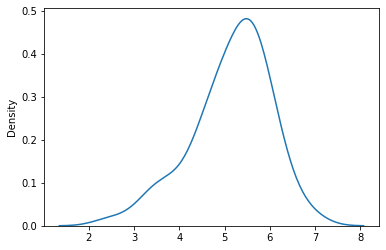

In [85]:
sns.kdeplot(dataset.squeeze())

In [58]:
# dataset = (dataset - dataset.mean()) / dataset.std()

In [59]:
# dataset = dataset / dataset.std()

In [60]:
# dataset = (dataset - dataset.median()) / dataset.std()

<AxesSubplot:ylabel='Density'>

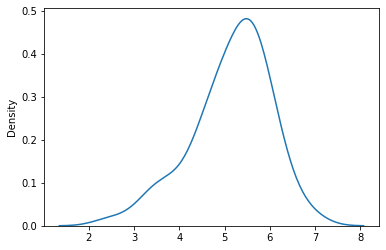

In [61]:
sns.kdeplot(dataset.squeeze())

In [62]:


import math
from functools import partial

import torch
import torch.nn as nn
from torch.distributions import Transform, constraints

from pyro.nn import DenseNN

from pyro.distributions.conditional import ConditionalTransformModule
from pyro.distributions.torch_transform import TransformModule


class ShiftScale(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, weights=None, bias=None, bound=None):
        super().__init__(cache_size=1)
        self.weights = weights
        self.bias = bias
        self.bound = bound

    def _call(self, x):
        assert len(x.shape) == 2
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.ones(self.input_dim) + a
        b = self.bias() if callable(self.bias) else self.bias
        return a * x + b

    def _inverse(self, y):
        assert len(y.shape) == 2
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.ones(self.input_dim) + a
        b = self.bias() if callable(self.bias) else self.bias
        return (y - b) / a

    def log_abs_det_jacobian(self, x, y):
        a = self.weights() if callable(self.weights) else self.weights
        a = torch.ones(self.input_dim) + a
        J = a.abs().log()
        assert len(J.shape) == 1
        return J.sum(-1)


class ShiftScaleTransform(ShiftScale, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim, bound=None):
        super().__init__(bound=bound)
        self.input_dim = input_dim
        self.weights = nn.Parameter(torch.Tensor(input_dim))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.reset_parameters()
        
        
    def reset_parameters(self):
#         stdv = 1e-3 * 1.0 / math.sqrt(self.input_dim)
#         self.weights.data.uniform_(-stdv, stdv)
        self.weights.data.zero_()
        self.bias.data.zero_()







In [63]:
class LowerCholeskyAffine(Transform):
    """
    A bijection of the form,

        :math:`\\mathbf{y} = \\mathbf{L} \\mathbf{x} + \\mathbf{r}`

    where `\\mathbf{L}` is a lower triangular matrix and `\\mathbf{r}` is a vector.

    :param loc: the fixed D-dimensional vector to shift the input by.
    :type loc: torch.tensor
    :param scale_tril: the D x D lower triangular matrix used in the transformation.
    :type scale_tril: torch.tensor

    """
    codomain = constraints.real_vector
    bijective = True
    event_dim = 1
    volume_preserving = False

    def __init__(self):
        super().__init__(cache_size=1)        
        
    def _get_scale_tril(self, input):
        d = self.input_dim
        scale_tril = torch.zeros(d, d, device=input.device)
        scale_tril[self.ix[0], self.ix[1]] = input
        scale_tril[range(d), range(d)] = torch.exp(scale_tril[range(d), range(d)])
        return scale_tril

    
    def _call(self, x):
        assert len(x.shape) == 2
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias
        scale_tril = self._get_scale_tril(self.weights)
        loc = self.bias
        return torch.matmul(scale_tril, x.unsqueeze(-1)).squeeze(-1) + loc

    def _inverse(self, y):
        assert len(y.shape) == 2
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias

        scale_tril = self._get_scale_tril(self.weights)
        loc = self.bias
        
        
        x = torch.linalg.solve_triangular(scale_tril, (y - loc).unsqueeze(-1),
                              upper=False).squeeze(-1)
        
        return x

    def log_abs_det_jacobian(self, x, y):
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias


        scale_tril = self._get_scale_tril(self.weights)
        J = torch.ones(x.size(), dtype=x.dtype, layout=x.layout, device=x.device) * \
            scale_tril.diag().log()
        assert len(J.shape) == 2
        J = J.sum(-1)
        return J
        
class LowerCholeskyAffineModule(LowerCholeskyAffine, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim):
        super().__init__()

        self.input_dim = input_dim
        self.weights = nn.Parameter(torch.Tensor(input_dim * (input_dim + 1) // 2))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.ix = torch.tril_indices(input_dim, input_dim)
        self.reset_parameters()

    
    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.input_dim)
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()


    



In [64]:
import math

class ConditionedAffineMatrixExponential(Transform):
    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, weights=None, bias=None, iterations=8, normalization="none", bound=None):
        super().__init__(cache_size=1)
        assert iterations > 0
        self.weights = weights
        self.bias = bias
        self.iterations = iterations
        self.normalization = normalization
        self.bound = bound

        # Currently, weight and spectral normalization are unimplemented. This doesn't effect the validity of the
        # bijection, although applying these norms should improve the numerical conditioning of the approximation.
        if normalization == "weight" or normalization == "spectral":
            raise NotImplementedError("Normalization is currently not implemented.")
        elif normalization != "none":
            raise ValueError("Unknown normalization method: {}".format(normalization))

    def _exp(self, x, M):
        
        power_term = x.unsqueeze(-1)
        y = x.unsqueeze(-1)
        for idx in range(self.iterations):
            power_term = torch.matmul(M, power_term) / (idx + 1)
            y = y + power_term

        return y.squeeze(-1)

    def _trace(self, M):
        return M.diagonal(dim1=-2, dim2=-1).sum(-1)

    def _call(self, x):
        assert len(x.shape) == 2
        M = self.weights() if callable(self.weights) else self.weights
        b = self.bias() if callable(self.bias) else self.bias

        return self._exp(x, M) + b

    def _inverse(self, y):
        assert len(y.shape) == 2

        b = self.bias() if callable(self.bias) else self.bias
        M = self.weights() if callable(self.weights) else self.weights
        return self._exp(y - b, -M)

    def log_abs_det_jacobian(self, x, y):
        """
        Calculates the element-wise determinant of the log Jacobian
        """

        M = self.weights() if callable(self.weights) else self.weights
        return self._trace(M)
    

class AffineMatrixExponentialModule(ConditionedAffineMatrixExponential, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim, iterations=8, normalization="none", bound=None):
        super().__init__(
            iterations=iterations, normalization=normalization, bound=bound
        )

        self.weights = nn.Parameter(torch.Tensor(input_dim, input_dim))
        self.bias = nn.Parameter(torch.Tensor(input_dim))
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1.0 / math.sqrt(self.weights.size(0))
        self.weights.data.uniform_(-stdv, stdv)
        self.bias.data.zero_()




In [65]:

class PositivePowerTransform(Transform):
    r"""
    Transform via the mapping
    :math:`y=\operatorname{sign}(x)|x|^{\text{exponent}}`.

    Whereas :class:`~torch.distributions.transforms.PowerTransform` allows
    arbitrary ``exponent`` and restricts domain and codomain to postive values,
    this class restricts ``exponent > 0`` and allows real domain and codomain.

    .. warning:: The Jacobian is typically zero or infinite at the origin.
    """
    domain = constraints.real
    codomain = constraints.real
    bijective = True
    sign = +1

    def __init__(self, exponent, *, cache_size=0, validate_args=None):
        super().__init__(cache_size=cache_size)
    
    def with_cache(self, cache_size=1):
        if self._cache_size == cache_size:
            return self
        return PositivePowerTransform(self.exponent, cache_size=cache_size)

    def _get_e(self):
#         return F.softplus(self.exponent)
#         return (torch.tanh(self.exponent / 2)).exp()
        return torch.exp(torch.tanh(32 * self.exponent))
#         return (0.1 * self.exponent).exp()

    def _call(self, x):
        assert len(x.shape) == 2
        e = self._get_e()
        return x.abs().pow(e) * x.sign()

    def _inverse(self, y):
        assert len(y.shape) == 2
        e = self._get_e()
        return y.abs().pow(e.reciprocal()) * y.sign()

    def log_abs_det_jacobian(self, x, y):
        e = self._get_e()
        J =  e.log() + (y / x).log()
        assert len(J.shape) == 2
        return J.sum(-1)


    def forward_shape(self, shape):
        e = self._get_e()
        return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


    def inverse_shape(self, shape):
        e = self._get_e()
        return torch.broadcast_shapes(shape, getattr(e, "shape", ()))


    
class PositivePowerTransformModule(PositivePowerTransform, TransformModule):

    domain = constraints.real_vector
    codomain = constraints.real_vector
    bijective = True

    def __init__(self, input_dim):
        super().__init__(None)
        self.exponent = nn.Parameter(torch.zeros(input_dim))



In [66]:
base_dist = dist.Normal(torch.zeros(d), torch.ones(d))
num_layers = 8
transform = []
for l in range(num_layers - 1):
    transform.append(ShiftScaleTransform(d))
#     transform.append(LowerCholeskyAffineModule(d))
#     transform.append(AffineMatrixExponentialModule(d))
    transform.append(PositivePowerTransformModule(d))
transform.append(ShiftScaleTransform(d))
# transform.append(LowerCholeskyAffineModule(d))
# transform.append(AffineMatrixExponentialModule(d))


transform_modules = nn.ModuleList([m for m in transform if isinstance(m, nn.Module)])
flow_dist = dist.TransformedDistribution(base_dist, transform)


In [67]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


count_parameters(transform_modules)

23

In [68]:
x = torch.linspace(-5, 5, 32)

In [69]:
flow_dist.log_prob(x[:, None]).shape

torch.Size([32])

In [70]:
y = flow_dist.sample((1024,))

In [71]:
y

tensor([[-0.9727],
        [ 0.9585],
        [ 1.6192],
        ...,
        [-0.7326],
        [ 0.4094],
        [-0.5841]])

<AxesSubplot:ylabel='Density'>

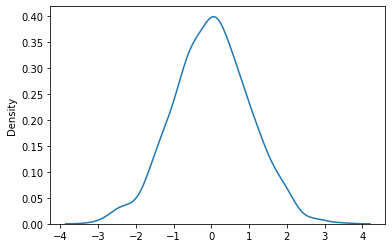

In [72]:
sns.kdeplot(y.detach().squeeze())

In [73]:
x = torch.linspace(-5, 5, 32768)

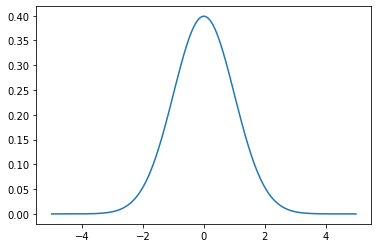

In [74]:
plt.plot(x, flow_dist.log_prob(x[:, None]).exp().detach().numpy().squeeze())

In [75]:
# matexp = MatrixExponential(d)

In [76]:
from torch.distributions.utils import _sum_rightmost


def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            assert torch.allclose(transform(x), y),  transform
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob
    
log_probs = log_prob(flow_dist, dataset)

ShiftScaleTransform() tensor(5.1416, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(5.1416, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(5.1416, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(5.1416, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(5.1416, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(5.1416, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(5.1416, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(5.1416, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(5.1416, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(5.1416, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(5.1416, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(5.1416, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(5.1416, grad_fn=<MeanBackward0>)
PositivePowerTransformModule() tensor(5.1416, grad_fn=<MeanBackward0>)
ShiftScaleTransform() tensor(5.1416, grad_fn=<MeanBackward0>)


In [77]:
def grad_norm(model):
    total_norm = 0
    parameters = [p for p in model.parameters() if p.grad is not None and p.requires_grad]
    for p in parameters:
        param_norm = p.grad.detach().data.norm(2)
        total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

In [78]:
def log_prob(transformed_dist, value):
        """
        Scores the sample by inverting the transform(s) and computing the score
        using the score of the base distribution and the log abs det jacobian.
        """
        if transformed_dist._validate_args:
            transformed_dist._validate_sample(value)
        event_dim = len(transformed_dist.event_shape)
        log_prob = 0.0
        y = value
        for transform in reversed(transformed_dist.transforms):
            x = transform.inv(y)
            print(transform, x.mean())
            event_dim += transform.domain.event_dim - transform.codomain.event_dim
            log_prob = log_prob - _sum_rightmost(transform.log_abs_det_jacobian(x, y),
                                                 event_dim - transform.domain.event_dim)
            y = x

        log_prob = log_prob + _sum_rightmost(transformed_dist.base_dist.log_prob(y),
                                             event_dim - len(transformed_dist.base_dist.event_shape))
        return log_prob


<AxesSubplot:ylabel='Density'>

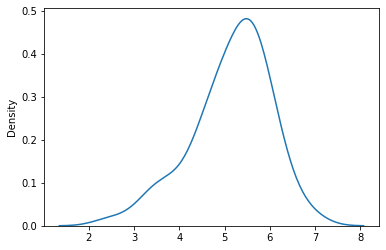

In [79]:
sns.kdeplot(dataset.squeeze())

step: 0, loss: 14.511748313903809


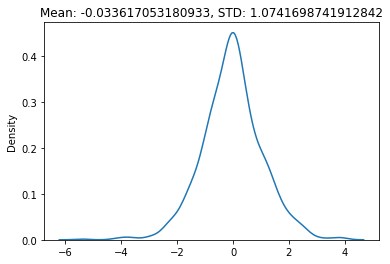

step: 500, loss: 1.6927318572998047


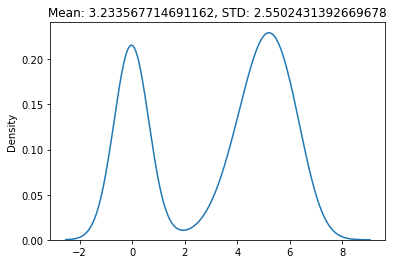

step: 1000, loss: 1.4782062768936157


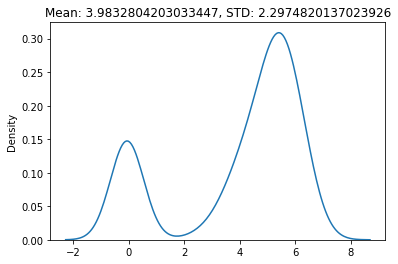

step: 1500, loss: 1.2937538623809814


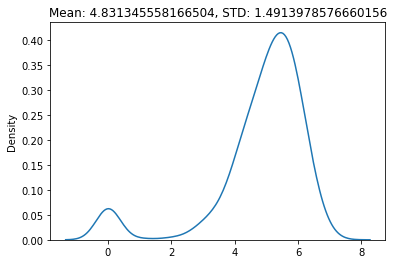

step: 2000, loss: 1.2367146015167236


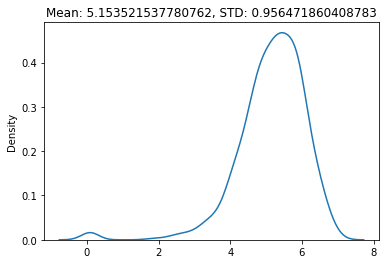

step: 2500, loss: 1.2340710163116455


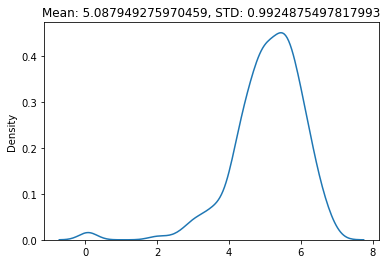

step: 3000, loss: 1.2336739301681519


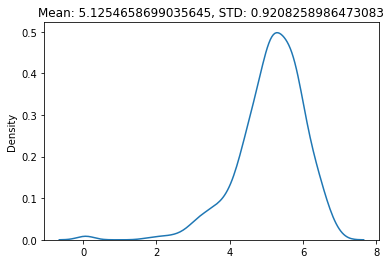

step: 3500, loss: 1.2332595586776733


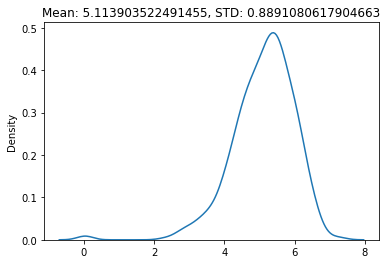

step: 4000, loss: 1.232993721961975


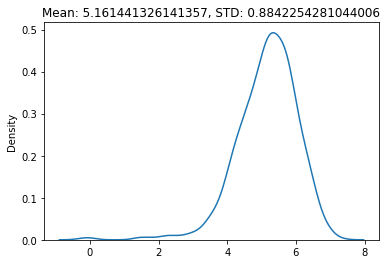

step: 4500, loss: 1.2332602739334106


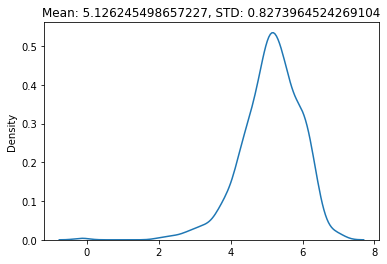

step: 5000, loss: 1.2338283061981201


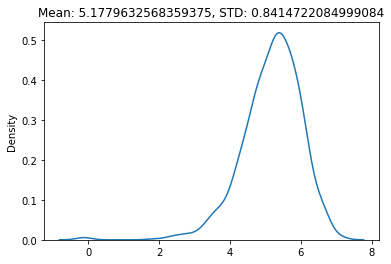

step: 5500, loss: 1.2323124408721924


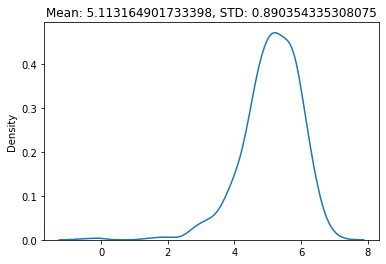

step: 6000, loss: 1.2332687377929688


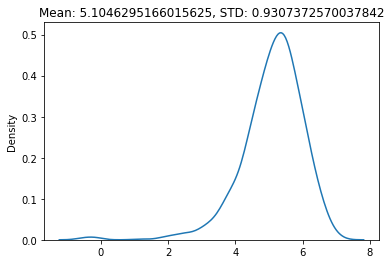

step: 6500, loss: 1.2336324453353882


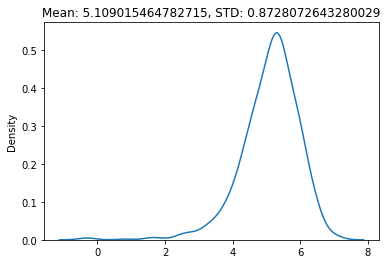

step: 7000, loss: 1.233364462852478


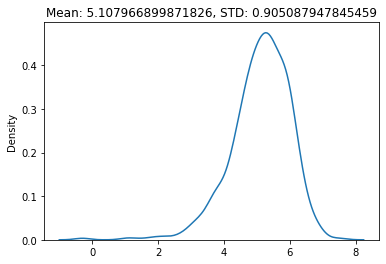

step: 7500, loss: 1.2316709756851196


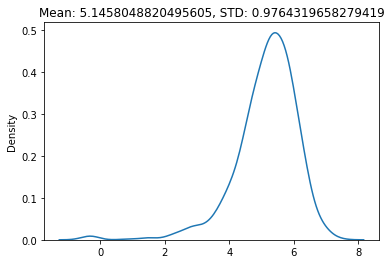

step: 8000, loss: 1.2320297956466675


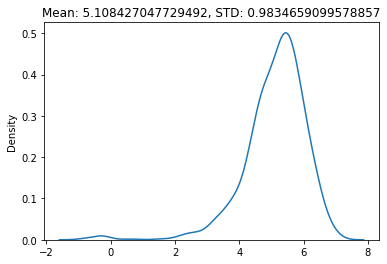

KeyboardInterrupt: 

In [80]:
steps = 32768
# optimizer = torch.optim.SGD(transform_modules.parameters(), momentum=0.5, lr=1e-1)
optimizer = torch.optim.Adam(transform_modules.parameters(), lr=1e-3)
# optimizer = torch.optim.RMSprop(transform_modules.parameters(), lr=1e-3, momentum=0.5)

losses = []
grad_norms = []

for step in range(steps+1):
    optimizer.zero_grad()
    loss = -flow_dist.log_prob(dataset).mean()
#     loss = -log_prob(flow_dist, dataset).mean()
    loss.backward()
    grad_norms.append(grad_norm(transform_modules))
#     torch.nn.utils.clip_grad_norm_(transform_modules.parameters(), 1)

    optimizer.step()
    flow_dist.clear_cache()
    losses.append(loss.item())
    
    
    
    
    if step % 500 == 0:
        print('step: {}, loss: {}'.format(step, loss.item()))

        sample = flow_dist.sample((1000,)).squeeze().numpy()
        sns.kdeplot(sample)
        plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")
        plt.show()

In [ ]:
plt.plot(losses)

In [ ]:
plt.plot(grad_norms)

In [ ]:
with torch.no_grad():
    sample = flow_dist.sample((1000,)).squeeze().numpy()
    sns.kdeplot(sample)
    plt.title(f"Mean: {sample.mean()}, STD: {sample.std()}")

In [ ]:
x = torch.linspace(0, 5, 128)

In [ ]:
plt.plot(x, flow_dist.log_prob(x[:, None]).exp().detach().numpy().squeeze())

In [ ]:
# 